In [ ]:
# Установка необходимых библиотек
%%capture
!sudo apt-get install tesseract-ocr-rus
!pip install pytesseract
!pip2 install matplotlib
!pip2 install ipykernel
!pip2 install pillow
!pip install datasets
!pip install jiwer

In [ ]:
# Импорт библиотек
import pytesseract
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jiwer
from collections import Counter
from datasets import load_metric

try:
 from PIL import Image
except ImportError:
 import Image

 %matplotlib inline 

In [ ]:
import glob
import random
import base64
from IPython.display import HTML
import io
import subprocess as sp
import os
import locale
os.environ["PYTHONIOENCODING"] = "utf-8"

pd.set_option('display.max_colwidth', None)

# Функции для отображения превью изображений
def get_thumbnail(path):
    path = "segmented/"+path
    i = Image.open(path)    
    i = i.resize((400, i.size[1]*(400//(i.size[0]))+10), Image.Resampling.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with io.BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/png;base64,{image_base64(im)}">'

In [ ]:
%%capture
%cd /content/drive/MyDrive/Colab Notebooks/nirs/data

# Загрузка данных

In [ ]:
# Загрузим файлы датасета в помощью библиотеки Pandas
test = pd.read_csv('data.csv', sep=";", encoding="cp1251")

,img,thumbnail,text
0,001.png,,"нуты самому внимательному изучения, но они повсюду"
1,002.png,,разил капитан
2,003.png,,"29 Найдите графы, геометрически двойственные к стереогра-"
3,004.png,,диционно входят в другие учебные курсы — такие как
4,005.png,,разобран и вынут. Временные фермовые крепления шахты

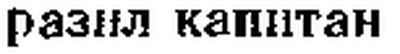

In [ ]:
# Первые 5 строк датасета + колонка с превью изображений
test_show = test.head().copy()
test_show['thumbnail'] = test.img.map(lambda f: get_thumbnail(f))
test_show = test_show.reindex(columns=['img','thumbnail', 'text'])
HTML(test_show.to_html(formatters={'thumbnail': image_formatter}, escape=False))

# Основные характеристики датасета

In [ ]:
# Размер датасета
test.shape

(425, 2)

In [ ]:
# Названия колонок
test.columns

Index(['img', 'text'], dtype='object')

In [ ]:
# Типы колонок
test.dtypes

img     object
text    object
dtype: object

In [ ]:
# Проверим наличие пустых значений
test.isnull().sum()

img     0
text    0
dtype: int64

# Построение графиков для понимания структуры данных

Размер датасета: 425
Максимальная длина текстовой строки: 64
Самый частый символ: о (1901 раз)


<BarContainer object of 84 artists>

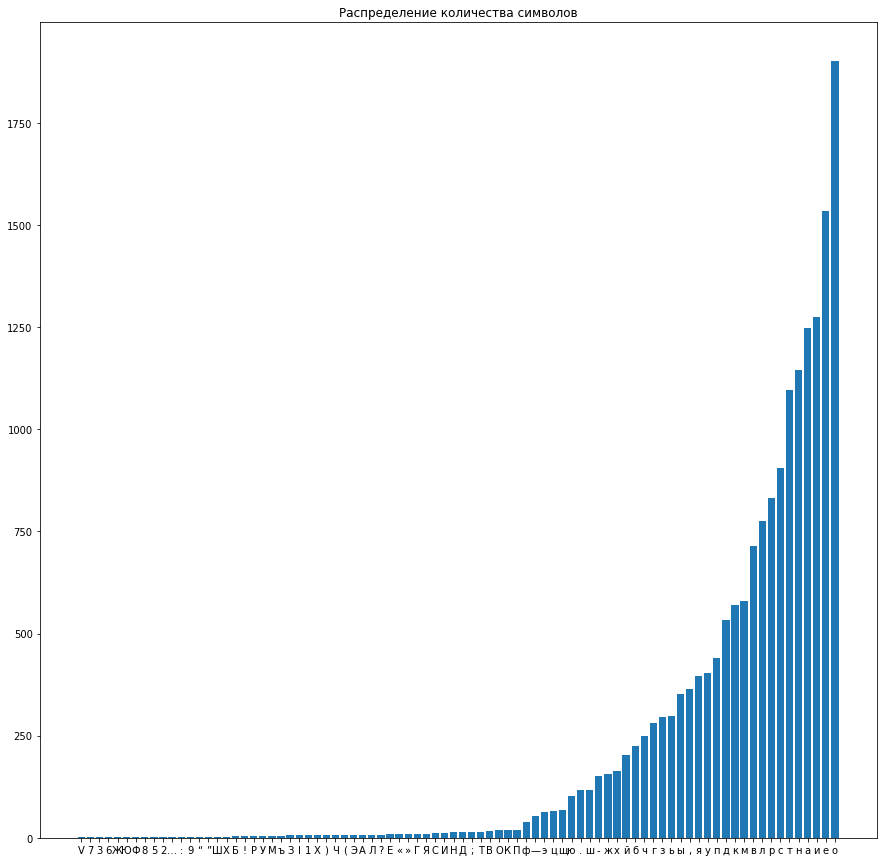

In [ ]:
# Диаграмма распределения символов в данных (без учета пробелов)
labels = test['text']

counter_length = {}
for lable in labels:
    L = len(lable)
    if L not in counter_length.keys():
        counter_length[L] = 0
    counter_length[L] += 1

labels = labels.map(lambda f: f.replace(" ", ""))
N = test.shape[0]
max_len = len(max(labels, key=len))

counter_chars = Counter(''.join(labels))
counter_chars = dict(sorted(counter_chars.items(), key=lambda item: item[1]))
max_char = list(counter_chars.items())[-1]
print('Размер датасета: '+str(N))
print('Максимальная длина текстовой строки: ' + str(max_len))
print('Самый частый символ: {} ({} раз)'.format(max_char[0],max_char[1]))

plt.figure(figsize=(15, 15))
plt.title('Распределение количества символов')
plt.bar(counter_chars.keys(), [counter_chars[key] for key in counter_chars.keys()])

<BarContainer object of 53 artists>

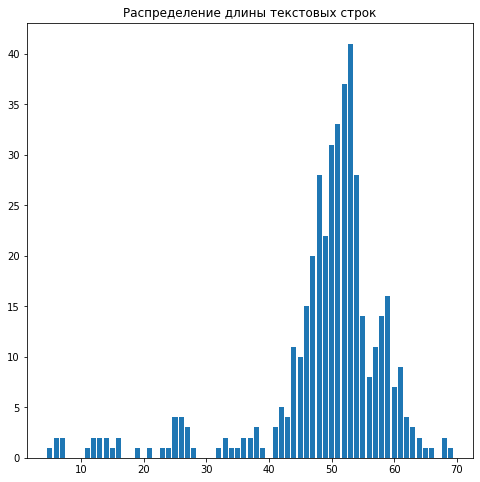

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Распределение длины текстовых строк')
plt.bar(counter_length.keys(), [counter_length[key] for key in counter_length.keys()])

# Метрики для оценки качества распознавания

В качестве метрики для оценки качества распознавания будем использовать метрики CER и WER:

CER показывает частоту неверно распознанных символов.

$CER = (S + D + I) / N$, где $S$ - количество замен символов, $D$ - количество удалений символов, $I$ - количество вставок символов, которые необходимы, чтобы получить из предсказанной строки истинную строку; $N$ - общее количество символов.

WER является аналогичной метрикой для оценки частоты неверно распознанных слов.

# Распознавание с помощью Tesseract

In [ ]:
pred_pytes_list = list()
for i in test['img']:
  img = Image.open("segmented/"+i)    
  pred_pytes_list.append(pytesseract.image_to_string(img, lang='rus', config='--psm 6').replace("\n", ""))
pred_pytes = pd.Series(pred_pytes_list)
pred_pytes.head()


0            нуты самому внимательному изучению, но они повсюду

1                                                 разнл капитан

2    20 Паидите графы, геометрически двоиствептые т. стореогра-

3            дициопно входят в другие учебиые курсы — такие как

4          разобрап и вынут. Временные фермовые крепления шахты

dtype: object

# Распознавание с помощью Ocropus

In [ ]:
%%capture
%cd /content/drive/MyDrive/Colab Notebooks/nirs/ocropy

In [ ]:
pred_ocropy_list = list()
for i in test['img']:
  path = '/content/drive/MyDrive/Colab Notebooks/nirs/data/segmented/'+i
  out = sp.getoutput("python2 ocropus-rpred -n -m cyrillic.pyrnn.gz '"+path+"'")
  pred_ocropy_list.append(out[out.rfind(":")+1:-1])
pred_ocropy = pd.Series(pred_ocropy_list)
pred_ocropy.head()

0    ыуты самому вниматеьному иучению, но оыи повсю,д
1                                         разнл капта
2     О адите траы. еомстримесьи двоствопле стереогрр
3      дищоно вмодыт в друте учрбштые ьурсы - ташо ьа
4     разобра и вынут, бремснне срмовые кротения шахт
dtype: object

# Сравнение качества распознавания

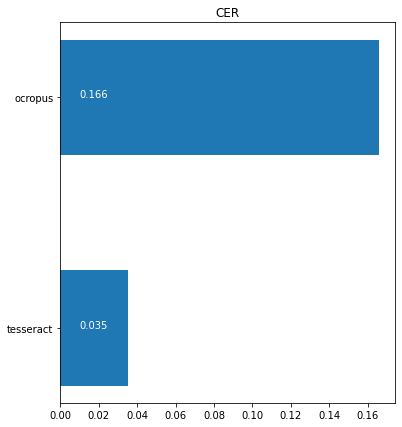

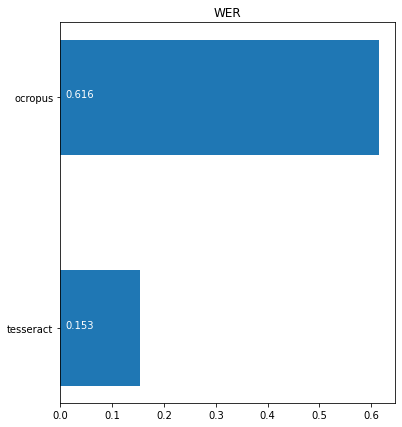

In [ ]:
cer = load_metric("cer")
tes_cer = cer.compute(predictions=pred_pytes, references=test['text'])
ocp_cer = cer.compute(predictions=pred_ocropy, references=test['text'])

tes_wer = jiwer.wer(test['text'].tolist(), pred_pytes.tolist())
ocp_wer = jiwer.wer(test['text'].tolist(), pred_ocropy.tolist())

# Вывод графиков
labels = ['tesseract', 'ocropus']
metric = [{'CER':[tes_cer, ocp_cer]},{'WER':[tes_wer, ocp_wer]}]

for mrx in metric:
  fig, ax1 = plt.subplots(figsize=(6,7))
  pos = np.arange(len(*mrx.values()))
  rects = ax1.barh(pos, *mrx.values(),
                         align='center',
                         height=0.5, 
                         tick_label=labels)
  ax1.set_title(str(*mrx))
  for a,b in zip(pos, *mrx.values()):
    plt.text(0.01, a, round(b,3), color='white')
plt.show()  


**Вывод:** количество ошибок при распознавании Tesseract намного ниже, чем в случае использования Ocropus, в основном по причине малого количества данных, использованных при обучении модели Ocropus.